In [1]:
# BITÁCORA DE CAMBIOS
# fe_2:     Lags simples
# fe_3:     Agregado multiple FE para fechas
# fe_4:     Arreglado los lags
# fe_5:     Agregado de los meses como seno y coseno
# fe_6:     Agrego features de Prophet
# fe_7:     Nueva tabla productos
# fe_8:     Modifico max_bins xgboost --> Kaggle: 0.255 
# fe_9:     Modifico sku_size como categorica
# fe_10:    Estandarizar todos los atributos y agrego el nuevo dataset de productos -> Empeora con xgboost depth 30, dejar en 15
# fe_11:    Voy a agregar un canario *3
# fe_12:    Voy a agregar un canario *10
# fe_13:    Agrego stocks
# fe_14:    Agregar product_id como variable del modelo
# fe_15:    Agrego clusters como categóricas
# fe_16:    Sku como numéricas y agrego 201910 como training y test
# fe_17:    Entrenamiento por clusters
# fe_18:    Data engineering lags 36
# fe_19:    Agrego algunas variables exogenas
# fe_19b:   Agrego algunas variables exogenas arreglo NAs
# fe_20:    Vector de pesos 
# fe_20b:   Vector de pesos + arreglo Prophet
# fe_20c:   Vector de pesos (arreglado) + arreglo Prophet
# fe_24:    Hyperparameters + 12 lags
# fe_25:    Hyperparameters + 12 lags sin exogenas

### Librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

import xgboost as xgb

import os
from datetime import datetime

from custom_fxs import crear_directorios_xp, cargar_datasets, feature_engineering, scaler_std, pipeline_fit_with_eval_set_weights, invert_transformation, plot_predictions, plot_top_features_importance, asignar_familia

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

import optuna

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

c:\Users\ferna\.conda\envs\labo3_311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Configuración experimento

In [3]:
EXPERIMENTO = "xgb_fe33"
MODELOS, PLOTS, PREDS, NB = crear_directorios_xp(EXPERIMENTO)

### Carga de datos

### Base

In [4]:
df_sells_filtrado, df_prods_filtrado, df_stocks_filtrado = cargar_datasets(filtrado=True)

In [5]:
df_prods_filtrado.sort_values(by=['descripcion', 'sku_size'], ascending=[True, True]).reset_index(drop=True)

,cat1,cat2,cat3,brand,sku_size,product_id,descripcion
0,PC,PIEL2,Toallitas Bebe,NIVEA,50,20642,AA
1,PC,DENTAL,CREMA,COLGATE,90,20883,AA
2,HC,VAJILLA,Cristalino,Importado,500,20524,Abrillantador
3,HC,VAJILLA,Cristalino,Importado,1000,20311,Abrillantador
4,PC,CABELLO,Acond Bebe,NIVEA,200,20783,Acondicinador Bebe
...,...,...,...,...,...,...,...
775,PC,CABELLO,ACONDICIONADOR,SHAMPOO3,650,20383,rulos vitales
776,PC,DEOS,Aero,SHAMPOO2,150,20945,sport
777,PC,DEOS,Aero,SHAMPOO2,150,20951,sport extremo
778,PC,PIEL1,CREMA,LANCOME,350,20538,trigo


### Familia de productos

In [6]:
df_prods_familia = pd.DataFrame(df_prods_filtrado)

# Crear nuevas columnas para los resultados
df_prods_familia['hermano_mayor'] = None
df_prods_familia['hermano_menor'] = None
df_prods_familia['mellizo'] = None

df_prods_familia = df_prods_familia.groupby(['cat1', 'cat2', 'cat3', 'brand', 'descripcion']).apply(asignar_familia).reset_index(drop=True)
df_prods_familia

C:\Users\ferna\AppData\Local\Temp\ipykernel_11808\620100813.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_prods_familia = df_prods_familia.groupby(['cat1', 'cat2', 'cat3', 'brand', 'descripcion']).apply(asignar_familia).reset_index(drop=True)


,cat1,cat2,cat3,brand,sku_size,product_id,descripcion,hermano_mayor,hermano_menor,mellizo
0,FOODS,ADEREZOS,Aji Picante,NATURA,240,20609,Salsa Aji Picante,[],[],None
1,FOODS,ADEREZOS,Barbacoa,NATURA,250,20266,Salsa Barbacoa,"[20325, 20503]",[],None
2,FOODS,ADEREZOS,Barbacoa,NATURA,400,20325,Salsa Barbacoa,[20503],[20266],None
3,FOODS,ADEREZOS,Barbacoa,NATURA,500,20503,Salsa Barbacoa,[],"[20266, 20325]",None
4,FOODS,ADEREZOS,Ketchup,MAJESTA,240,20299,Ketchup,[],[],None
...,...,...,...,...,...,...,...,...,...,...
775,REF,TE,Especial,TWININGS,20,21170,EG,[],[],None
776,REF,TE,Hierbas,TWININGS,20,21202,Manzanilla,[],[],None
777,REF,TE,Hierbas,TWININGS,20,21218,Menta,[],[],None
778,REF,TE,Verde,TWININGS,20,21192,Verde,[],[],None


### Pruebo agregar columnas de familia

In [7]:
df_sells_agg = df_sells_filtrado.groupby(['product_id', 'periodo','plan_precios_cuidados']).agg({'tn': 'sum','cust_request_qty': 'sum','cust_request_tn': 'sum'}).reset_index()

df2 = df_sells_agg.merge(df_prods_familia[['product_id', 'hermano_mayor', 'hermano_menor', 'mellizo']], on='product_id', how='left')

In [8]:
def get_tn(df, product_list, period):
    return df[(df['product_id'].isin(product_list)) & (df['periodo'] == period)]['tn'].tolist()

for i in range(len(df2)):
    period = df2.loc[i, 'periodo']
    mayor_list = df2.loc[i, 'hermano_mayor']
    menor_list = df2.loc[i, 'hermano_menor']
    twin_id = df2.loc[i, 'mellizo']
    
    mayor_tn = get_tn(df2, mayor_list, period) if mayor_list else []
    menor_tn = get_tn(df2, menor_list, period) if menor_list else []  
    twin_tn = get_tn(df2, twin_id, period) if isinstance(twin_id, list) else []
    
    for j, tn in enumerate(mayor_tn):
        df2.at[i, f'hermano_mayor_{j+1}'] = tn
    for j, tn in enumerate(menor_tn):
        df2.at[i, f'hermano_menor_{j+1}'] = tn
    df2.at[i, 'mellizo_tn'] = twin_tn[0] if twin_tn else None

df2 = df2.drop(columns=['hermano_mayor', 'hermano_menor', 'mellizo'])

df2

,product_id,periodo,plan_precios_cuidados,tn,cust_request_qty,cust_request_tn,hermano_menor_1,mellizo_tn,hermano_menor_2,hermano_menor_3,hermano_mayor_1,hermano_mayor_2,hermano_mayor_3,hermano_mayor_4,hermano_menor_4
0,20001,201701,0,934.77222,479,937.72717,114.16856,116.86614,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20001,201702,0,798.01620,432,833.72187,157.94664,68.92650,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20001,201703,0,1303.35771,509,1330.74697,157.61530,159.98159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20001,201704,0,1069.96130,279,1132.94430,190.20933,77.07501,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20001,201705,0,1502.20132,701,1550.68936,184.94423,125.65265,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22344,21276,201908,0,0.01265,7,0.01265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22345,21276,201909,0,0.01856,10,0.01856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22346,21276,201910,0,0.02079,13,0.02079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22347,21276,201911,0,0.03341,12,0.03341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_prods_familia.query("product_id == 20102")

,cat1,cat2,cat3,brand,sku_size,product_id,descripcion,hermano_mayor,hermano_menor,mellizo
249,HC,ROPA LAVADO,Liquido,ARIEL,3000,20102,genoma,[],"[20261, 20045, 20150]",[20001]


In [10]:
df2.query("product_id == 20102")

,product_id,periodo,plan_precios_cuidados,tn,cust_request_qty,cust_request_tn,hermano_menor_1,mellizo_tn,hermano_menor_2,hermano_menor_3,hermano_mayor_1,hermano_mayor_2,hermano_mayor_3,hermano_mayor_4,hermano_menor_4
3204,20102,201701,0,116.86614,231,118.09737,114.16856,934.77222,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3205,20102,201702,0,68.92650,226,71.83668,157.94664,798.01620,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3206,20102,201703,0,159.98159,336,161.14566,157.61530,1303.35771,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3207,20102,201704,0,77.07501,226,77.07501,190.20933,1069.96130,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3208,20102,201705,0,125.65265,302,125.65265,184.94423,1502.20132,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3209,20102,201706,0,101.58766,337,101.58767,190.27205,1520.06539,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3210,20102,201707,0,86.84650,191,86.84650,152.54712,1030.67391,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3211,20102,201708,0,76.86229,282,76.86231,161.09854,1267.39462,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3212,20102,201709,0,70.72858,271,70.72858,211.82531,1316.94604,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3213,20102,201710,0,123.78344,280,123.78344,219.67831,1439.75563,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df2.query("product_id == 20001")

,product_id,periodo,plan_precios_cuidados,tn,cust_request_qty,cust_request_tn,hermano_menor_1,mellizo_tn,hermano_menor_2,hermano_menor_3,hermano_mayor_1,hermano_mayor_2,hermano_mayor_3,hermano_mayor_4,hermano_menor_4
0,20001,201701,0,934.77222,479,937.72717,114.16856,116.86614,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20001,201702,0,798.01620,432,833.72187,157.94664,68.92650,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20001,201703,0,1303.35771,509,1330.74697,157.61530,159.98159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20001,201704,0,1069.96130,279,1132.94430,190.20933,77.07501,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20001,201705,0,1502.20132,701,1550.68936,184.94423,125.65265,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,20001,201706,0,1520.06539,570,1575.82891,190.27205,101.58766,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,20001,201707,0,1030.67391,381,1086.47101,152.54712,86.84650,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,20001,201708,0,1267.39462,643,1289.66869,161.09854,76.86229,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,20001,201709,0,1316.94604,381,1356.96103,211.82531,70.72858,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,20001,201710,0,1439.75563,273,1441.60247,219.67831,123.78344,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Prophet

In [12]:
prophet_data = "prophet_fe_data.csv"
df_prophet = pd.read_csv(prophet_data, decimal='.', delimiter=',', encoding='utf-8')

columnas= ['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 
                          'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 
                          'yearly', 'yearly_lower', 'yearly_upper']

#for columna in columnas:
#    df_prophet[columna] = df_prophet[columna].apply(lambda x: max(x, 0))
    
df_prophet['periodo'] = pd.to_datetime(df_prophet['ds'], format='%Y-%m-%d')
df_prophet['periodo'] = df_prophet['periodo'].dt.strftime('%Y%m').astype(int)

columnas_seleccionadas= ['periodo', 'product_id', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 
                          'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 
                          'yearly', 'yearly_lower', 'yearly_upper']

df_prophet = df_prophet[columnas_seleccionadas]

### Agrupación y joins

In [13]:
# Agrupo por PRODUCT_ID + PERIODO
df_sells_agg = df_sells_filtrado.groupby(['product_id', 'periodo','plan_precios_cuidados']).agg({'tn': 'sum','cust_request_qty': 'sum','cust_request_tn': 'sum'}).reset_index()

# JOIN tb_productos
df_sells_agg  = df_sells_agg.merge(df_prods_filtrado, on='product_id', how='left')

# JOIN stocks
df_sells_agg  = df_sells_agg.merge(df_stocks_filtrado, on=['product_id', 'periodo'], how='left')

# JOIN data Pophet
df_sells_agg  = df_sells_agg.merge(df_prophet, on=['product_id', 'periodo'], how='left')

# JOIN con Clusters
#cl5 = pd.read_csv("../Datasets/5_clusters.csv", index_col=False)
#cl10 = pd.read_csv("../Datasets/10_clusters.csv", index_col=False)
#cl20 = pd.read_csv("../Datasets/20_clusters.csv", index_col=False)
cl50 = pd.read_csv("../Datasets/50_clusters.csv", index_col=False)
#cl100 = pd.read_csv("../Datasets/100_clusters.csv", index_col=False)

#df_sells_agg = df_sells_agg.merge(cl5.rename(columns={'cluster': 'cluster_5'}), on='product_id', how='left')
#df_sells_agg = df_sells_agg.merge(cl10.rename(columns={'cluster': 'cluster_10'}), on='product_id', how='left')
#df_sells_agg = df_sells_agg.merge(cl20.rename(columns={'cluster': 'cluster_20'}), on='product_id', how='left')
df_sells_agg = df_sells_agg.merge(cl50.rename(columns={'cluster': 'cluster_50'}), on='product_id', how='left')
#df_sells_agg = df_sells_agg.merge(cl100.rename(columns={'cluster': 'cluster_100'}), on='product_id', how='left')

df_sells_agg.head()

,product_id,periodo,plan_precios_cuidados,tn,cust_request_qty,cust_request_tn,cat1,cat2,cat3,brand,sku_size,descripcion,stock_final,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,cluster_50
0,20001,201701,0,934.77222,479,937.72717,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN,1253.736016,658.150779,1335.665069,1253.736016,1253.736016,-240.118444,-240.118444,-240.118444,-240.118444,-240.118444,-240.118444,16
1,20001,201702,0,798.01620,432,833.72187,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN,1262.235256,552.200472,1185.622572,1262.235256,1262.235256,-391.702066,-391.702066,-391.702066,-391.702066,-391.702066,-391.702066,16
2,20001,201703,0,1303.35771,509,1330.74697,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN,1271.645129,1169.577591,1836.598993,1271.645129,1271.645129,241.601638,241.601638,241.601638,241.601638,241.601638,241.601638,16
3,20001,201704,0,1069.96130,279,1132.94430,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN,1280.751458,743.639264,1375.402442,1280.751458,1280.751458,-215.814799,-215.814799,-215.814799,-215.814799,-215.814799,-215.814799,16
4,20001,201705,0,1502.20132,701,1550.68936,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN,1290.161331,1094.231747,1724.686243,1290.161331,1290.161331,118.402960,118.402960,118.402960,118.402960,118.402960,118.402960,16


### Variables exogenas

In [14]:
df_exogenas = pd.read_excel("../Datasets/exogenas.xlsx", index_col=False)
df_sells_agg  = df_sells_agg.merge(df_exogenas, on='periodo', how='left')

### Alpiste para canario

In [15]:
#df_sells_agg = producto_canario(df_sells_agg)

### Estandarizo cada serie

In [16]:
columnas_escalar = [
    'cust_request_tn', 'trend', 'yhat_lower', 'yhat_upper', 
    'trend_lower', 'trend_upper', 'additive_terms', 
    'additive_terms_lower', 'additive_terms_upper', 
    'yearly', 'yearly_lower', 'yearly_upper', 'stock_final'
]

In [17]:
df_transformed, scaler_dict = scaler_std(df_sells_agg, columnas_escalar)

c:\Users\ferna\.conda\envs\labo3_311\Lib\site-packages\sklearn\utils\extmath.py:1140: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\ferna\.conda\envs\labo3_311\Lib\site-packages\sklearn\utils\extmath.py:1145: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\ferna\.conda\envs\labo3_311\Lib\site-packages\sklearn\utils\extmath.py:1165: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


### Feature Engineering

In [18]:
df_fe = feature_engineering(df_transformed, 36)

### Imputo los nulos

In [19]:
#df_merged_agg_final = df_fe.fillna(0)
df_merged_agg_final = df_fe

In [20]:
column = df_merged_agg_final.pop('tn')
df_merged_agg_final['tn'] = column
df_merged_agg_final

,product_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,cat1,cat2,cat3,brand,sku_size,descripcion,stock_final,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,cluster_50,dólar_oficial,ipc,receso_escolar,feriados,anomalia,dividendos,ADR,weights,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,delta_lag_1,delta_lag_2,delta_lag_3,delta_lag_4,delta_lag_5,delta_lag_6,delta_lag_7,delta_lag_8,delta_lag_9,delta_lag_10,delta_lag_11,delta_lag_12,delta_lag_13,delta_lag_14,delta_lag_15,delta_lag_16,delta_lag_17,delta_lag_18,delta_lag_19,delta_lag_20,delta_lag_21,delta_lag_22,delta_lag_23,delta_lag_24,delta_lag_25,delta_lag_26,delta_lag_27,delta_lag_28,delta_lag_29,delta_lag_30,delta_lag_31,delta_lag_32,delta_lag_33,delta_lag_34,moving_avg_1,moving_avg_2,moving_avg_3,moving_avg_4,moving_avg_5,moving_avg_6,moving_avg_7,moving_avg_8,moving_avg_9,moving_avg_10,moving_avg_11,moving_avg_12,moving_avg_13,moving_avg_14,moving_avg_15,moving_avg_16,moving_avg_17,moving_avg_18,moving_avg_19,moving_avg_20,moving_avg_21,moving_avg_22,moving_avg_23,moving_avg_24,moving_avg_25,moving_avg_26,moving_avg_27,moving_avg_28,moving_avg_29,moving_avg_30,moving_avg_31,moving_avg_32,moving_avg_33,moving_avg_34,moving_avg_35,ratio_3,ratio_6,max_2_months,min_2_months,max_3_months,min_3_months,max_4_months,min_4_months,max_5_months,min_5_months,max_6_months,min_6_months,max_7_months,min_7_months,max_8_months,min_8_months,max_9_months,min_9_months,max_10_months,min_10_months,max_11_months,min_11_months,max_12_months,min_12_months,max_13_months,min_13_months,max_14_months,min_14_months,max_15_months,min_15_months,max_16_months,min_16_months,max_17_months,min_17_months,max_18_months,min_18_months,max_19_months,min_19_months,max_20_months,min_20_months,max_21_months,min_21_months,max_22_months,min_22_months,max_23_months,min_23_months,max_24_months,min_24_months,max_25_months,min_25_months,max_26_months,min_26_months,max_27_months,min_27_months,max_28_months,min_28_months,max_29_months,min_29_months,max_30_months,min_30_months,max_31_months,min_31_months,max_32_months,min_32_months,max_33_months,min_33_months,max_34_months,min_34_months,max_35_months,min_35_months,max_36_months,min_36_months,Year,Month,Q,Days_Month,month_sin,month_cos,tn
0,20001,2017-01-01,0,479,-1.704215,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN,-1.685675,-1.704389,-1.580634,-1.685675,-1.685675,-1.067345,-1.067345,-1.067345,-1.067345,-1.067345,-1.067345,16,15.70,0.000,Yes,1,No,No,31.86,1454.732720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2017,1,3,31,5.000000e-01,8.660254e-01,-1.576908
1,20001,2017-02-01,0,432,-2.039835,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN,-1.596484,-2.138462,-2.196954,-1.596484,-1.596484,-1.789274,-1.789274,-1.789274,-1.789274,-1.789274,-1.789274,16,15.30,0.000,Yes,2,No,Yes,36.80,1454.732720,-1.576908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.576908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

### Agrego el target

In [21]:
df_merged_agg_final['target'] = df_merged_agg_final.groupby('product_id')['tn'].shift(-2)

### Split Temporal

In [22]:
numeric_columns = df_merged_agg_final.select_dtypes(include=['number']).columns.tolist()
numeric_columns = [col for col in numeric_columns if col not in ['target']]

categorical_columns = df_merged_agg_final.select_dtypes(include=['object']).columns.tolist()
categorical_columns = [col for col in categorical_columns if col not in ['periodo']]

categorical_columns.append('plan_precios_cuidados')

numeric_columns.remove('plan_precios_cuidados')
numeric_columns.remove('weights')

In [23]:
for col in categorical_columns:
    df_merged_agg_final[col] = df_merged_agg_final[col].astype("category")

In [24]:
df_merged_agg_final['periodo'] = pd.to_datetime(df_merged_agg_final['periodo'], format='%Y%m')

train = df_merged_agg_final[df_merged_agg_final['periodo'] < pd.to_datetime('201910', format='%Y%m')]
validation = df_merged_agg_final[df_merged_agg_final['periodo'] == pd.to_datetime('201910', format='%Y%m')]

test = df_merged_agg_final[df_merged_agg_final['periodo'] > pd.to_datetime('201910', format='%Y%m')]

In [25]:
X_train = train.drop(columns=['target', 'weights'])
y_train = train['target']
w_train = train['weights']

X_validation = validation.drop(columns=['target', 'weights'])
y_validation = validation['target']
w_validation = validation['weights']

test.drop(columns=['target', 'weights'], inplace=True)

C:\Users\ferna\AppData\Local\Temp\ipykernel_11808\1635910362.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(columns=['target', 'weights'], inplace=True)


### Train XGBoost

In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('num', 'passthrough', numeric_columns)
    ],
    remainder='drop'
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_validation_transformed = preprocessor.transform(X_validation)
X_test_transformed = preprocessor.transform(test)

In [27]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'objective': 'reg:squarederror',
        'early_stopping_rounds': 50,
        'max_bin': 1023,
        'enable_categorical': True,
        'eval_metric': 'rmse'
    }
    
    model = xgb.XGBRegressor(**params)
    
    model.fit(X_train_transformed, y_train, sample_weight=w_train, eval_set=[(X_validation_transformed, y_validation)], verbose=False)
    
    preds = model.predict(X_validation_transformed)
    rmse = np.sqrt(mean_squared_error(y_validation, preds))
    
    with open(PREDS + f"{EXPERIMENTO}_optuna_log.txt", "a") as log_file:
        log_file.write(f"Trial {trial.number}: RMSE={rmse}, Params={params}\n")
    
    return rmse

In [28]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-07-07 11:34:05,448] A new study created in memory with name: no-name-842e04ff-fc6f-436e-9bd5-b40cdfa80f70
[W 2024-07-07 11:37:18,737] Trial 0 failed with parameters: {'max_depth': 17, 'learning_rate': 0.054533265728094235, 'n_estimators': 557, 'min_child_weight': 8, 'subsample': 0.9549954642529437, 'colsample_bytree': 0.9883769199211743, 'reg_alpha': 0.2282112251503151, 'reg_lambda': 0.47574969281540225} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\ferna\.conda\envs\labo3_311\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\ferna\AppData\Local\Temp\ipykernel_11808\581397347.py", line 20, in objective
    model.fit(X_train_transformed, y_train, sample_weight=w_train, eval_set=[(X_validation_transformed, y_validation)], verbose=False)
  File "c:\Users\ferna\.conda\envs\labo3_311\Lib\site-packages\xgboost\core.py", li

KeyboardInterrupt: 

### Mejores parámetros

In [ ]:
best_params = study.best_params

with open(PREDS + f"{EXPERIMENTO}_best_params.txt", "w") as f:
    f.write(str(best_params))

### Predicción con mejores parámetros

In [ ]:
final_model = xgb.XGBRegressor(**best_params)

final_model.fit(X_train_transformed, y_train, sample_weight=w_train, eval_set=[(X_validation_transformed, y_validation)],eval_metric="rmse", verbose=False)

predictions = final_model.predict(X_test_transformed)

c:\Users\ferna\.conda\envs\labo3_311\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


In [ ]:
def generate_primes(n):
    primes = []
    num = 2
    while len(primes) < n:
        is_prime = all(num % i != 0 for i in range(2, int(np.sqrt(num)) + 1))
        if is_prime:
            primes.append(num)
        num += 1
    return primes

In [ ]:
# Entrenar y predecir con 100 semillas diferentes
SEMILLAS = 100
seeds = generate_primes(SEMILLAS)
all_predictions = []

for seed in seeds:
    model = xgb.XGBRegressor(random_state=seed, **best_params)
    model.fit(X_train_transformed, y_train, sample_weight=w_train, eval_set=[(X_validation_transformed, y_validation)],eval_metric="rmse", verbose=False)
    y_pred = model.predict(X_test_transformed)
    all_predictions.append(y_pred)

# Calcular la predicción final como el promedio de las predicciones obtenidas con las diferentes semillas
predictions_seeds = np.mean(all_predictions, axis=0)

### Guardo el modelo

In [ ]:
final_model.save_model(MODELOS + f"/{EXPERIMENTO}.json")

### Feature Importance

In [ ]:
data = list(zip(X_train.columns, final_model.feature_importances_))
new_df = pd.DataFrame(data, columns =['Feature', 'Importance'])
new_df = new_df.sort_values(by='Importance', ascending=False)

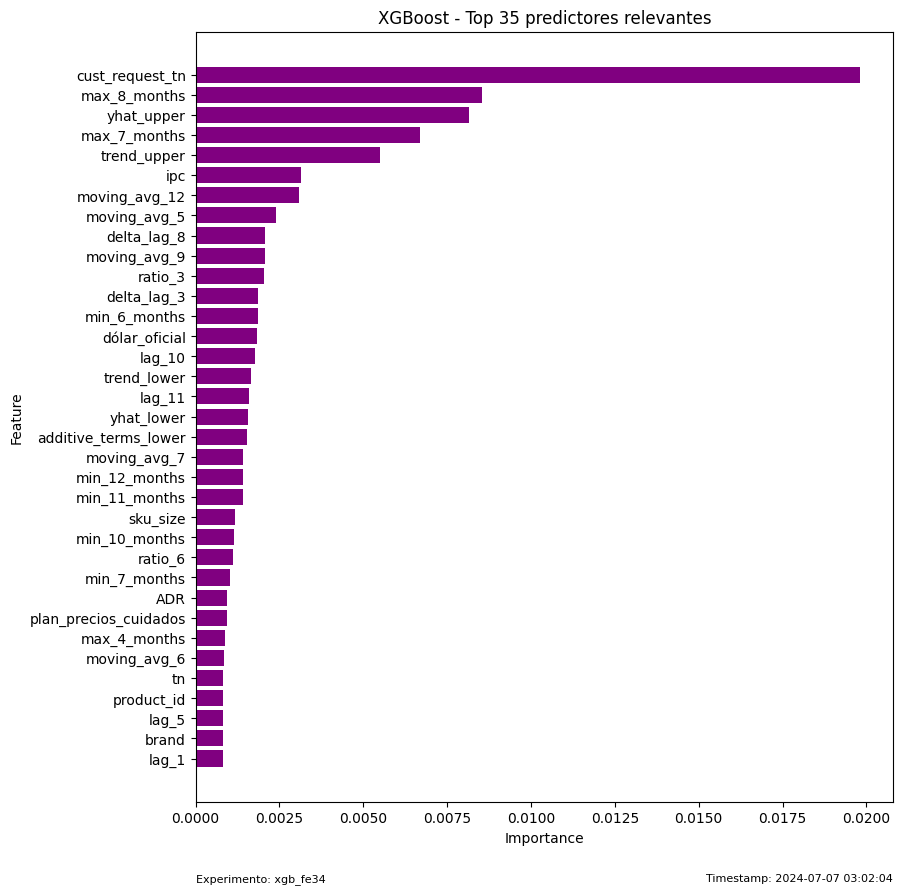

In [ ]:
plot_top_features_importance(new_df, 35, EXPERIMENTO, PLOTS)

### Prediccion

In [ ]:
df_test_202002 = test[['product_id', 'tn']]
df_test_202002['periodo'] = ['202001' if i % 2 == 0 else '202002' for i in range(len(test))]
df_test_202002['pred'] = predictions
df_test_202002['pred_seeds'] = predictions_seeds

df_test_202002 = df_test_202002[['product_id', 'periodo', 'tn', 'pred', 'pred_seeds']].query("periodo == '202002'")

C:\Users\ferna\AppData\Local\Temp\ipykernel_20620\106165682.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_202002['periodo'] = ['202001' if i % 2 == 0 else '202002' for i in range(len(test))]
C:\Users\ferna\AppData\Local\Temp\ipykernel_20620\106165682.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_202002['pred'] = predictions
C:\Users\ferna\AppData\Local\Temp\ipykernel_20620\106165682.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [ ]:
df_test_202002

,product_id,periodo,tn,pred,pred_seeds
35,20001,202002,0.361745,-0.079784,0.181760
71,20002,202002,0.260161,0.015533,0.242313
107,20003,202002,0.012145,-0.366533,-0.263857
143,20004,202002,-0.152344,-0.729455,-0.619519
179,20005,202002,-0.236762,-0.866011,-0.954978
...,...,...,...,...,...
22308,21263,202002,-0.516487,-0.605347,-0.512403
22318,21265,202002,-0.382399,0.264691,0.331831
22328,21266,202002,-0.432199,0.132652,0.244489
22338,21267,202002,-1.017256,0.292414,0.280979


### Invierto la escala

In [ ]:
# Para invertir la transformación
def invert_transformation(scaled_value, product_id):
    mean_val, std_val = scaler_dict[product_id]
    original_value = scaled_value * std_val + mean_val
    return original_value

# Invertir las predicciones
original_predictions = [invert_transformation(pred, pid) for pred, pid in zip(df_test_202002['pred'], df_test_202002['product_id'])]
original_predictions_seeds = [invert_transformation(pred, pid) for pred, pid in zip(df_test_202002['pred_seeds'], df_test_202002['product_id'])]

df_test_202002['target'] = original_predictions
df_test_202002['target_seeds'] = original_predictions_seeds


### Armo el df final

In [ ]:
df_final = df_test_202002[['product_id', 'target', 'target_seeds']].reset_index(drop=True)
df_final

,product_id,target,target_seeds
0,20001,1374.889838,1451.777358
1,20002,1014.021717,1081.961553
2,20003,783.460407,813.026103
3,20004,510.179072,534.509224
4,20005,457.817388,438.669878
...,...,...,...
775,21263,-0.000467,0.013305
776,21265,0.116862,0.123792
777,21266,0.107995,0.119237
778,21267,0.115011,0.114143


### Kaggle

In [ ]:
df_kaggle = df_final[['product_id', 'target_seeds']]
df_kaggle.rename(columns={'target_seeds':'tn'}, inplace=True)

df_kaggle.to_csv(PREDS + f"/multinacional_{EXPERIMENTO}.csv", float_format='%.6f', decimal='.', index=False)

C:\Users\ferna\AppData\Local\Temp\ipykernel_20620\1815566569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kaggle.rename(columns={'target_seeds':'tn'}, inplace=True)
